In [20]:
import os, sys
sys.path.insert(0,"../")
import time
print(os.getcwd())

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import dopt
from dopt import Trainer
from dopt.synthetic_trainers import NegHartmannTrainer
dopt.__file__

/home/tung/summer/notebooks


'../dopt/__init__.py'

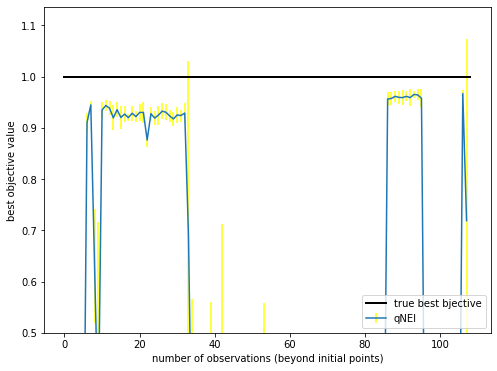

In [422]:
from botorch.test_functions.synthetic import Hartmann


FILE_NAME = "../yaleface_first.json"


def visualize():
    # Load the data
    train_obj_nei, train_yvar_nei = [], []
    with open(FILE_NAME, "r") as f:
        for line in f.readlines():
            observation = json.loads(line)
            train_obj_nei.append(observation["result"][0])
            train_yvar_nei.append(np.sqrt(observation["result"][1]))

#     neg_hartmann6 = Hartmann(negate=True)
#     GLOBAL_MAXIMUM = neg_hartmann6.optimal_value
    GLOBAL_MAXIMUM = 1

    iters = np.arange(max(len(train_obj_nei), len(train_obj_nei)))
    y_nei = np.array(train_obj_nei)
    y_err = np.array(train_yvar_nei)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.errorbar(iters, y_nei, yerr=y_err, label="qNEI", linewidth=1.5, ecolor=['yellow'])
    plt.plot([0, iters.shape[0]], [GLOBAL_MAXIMUM] * 2, 'k', label="true best bjective", linewidth=2)
    ax.set_ylim(bottom=0.5)
    ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
    ax.legend(loc="lower right")
    plt.show()

count = 0
while count < 200:
    visualize()
    clear_output(wait=True)
    time.sleep(2)
    count += 1

# -------------- DRAFT --------------

In [1]:
import os, sys
sys.path.insert(0,"../")
sys.path.append("/opt/anaconda/envs/jupyter37/lib/python3.7/site-packages")
import time
print(os.getcwd())

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import dopt
from dopt import Trainer
from dopt.synthetic_trainers import NegHartmannTrainer
dopt.__version__

/home/tung/summer/notebooks


'0.0.2.5'

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [13]:
# Util: Mute prints within
from contextlib import contextmanager
import sys, os

from time import sleep
from IPython.display import clear_output
import logging

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import animation, rc
from IPython.display import HTML

from dopt import NEIOptimizer
from botorch import *
from botorch import fit_gpytorch_model
from botorch.models import HeteroskedasticSingleTaskGP, FixedNoiseGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from celluloid import Camera
import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams['animation.embed_limit'] = 2**32
logging.basicConfig(level="warning")

@contextmanager
def mute_print(mute=True):
    if mute == True:
        original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        yield
        sys.stdout = original_stdout

from botorch.test_functions import HolderTable

BASE_VAR = 0.1

def objective_function(X):
    X = -X
    mask_constraint = torch.sum(X, dim=-1) < 10
    cos_x = torch.cos(X[...,0])
    sin_y = torch.sin(X[...,1])
    first_term = sin_y * torch.exp((1-cos_x)**2)
    second_term = cos_x * torch.exp((1-sin_y)**2)
    third_term = (X[...,0] - X[...,1])**2
    result = -(first_term + second_term + third_term) 
    return ((result + 120) / 230) * mask_constraint

def objective(X):
    Y = objective_function(X.view(-1, 2))
#     return Y
    se = torch.norm(X, dim=-1, keepdim=True) * 0.02
    Yvar = BASE_VAR + se * torch.rand_like(se)
    true_var = BASE_VAR + se
    Y = Y.view(-1, 1, 1) + torch.rand_like(se) * Yvar
    return Y, Yvar.view_as(Y)**2, true_var.view_as(Y)**2

def sample_model_posterior(model, X):
    p = model.posterior(X.view(-1,1,2), observation_noise=True)
    mean = p.mean[:,:,0]
    variance = ((p.mvn.confidence_region()[1][...,0] - mean) / 2) ** 2 # Using upper bound
    return mean, variance 

def constraint(candidate):
    return (candidate["x1"] + candidate["x2"] - 10)

In [16]:
EPSILON = 10**(-4)

bounds = {
    "x1": [0, 10],
    "x2": [0, 10]
}
optimizer = NEIOptimizer("test.dopt", bounds, device="cuda:0", seed=1)

X = torch.cartesian_prod(torch.arange(0,1,0.01, dtype=torch.double), torch.arange(0,1,0.01, dtype=torch.double))\
                            .view(-1,1,2) * 10
X = X.to("cuda:0")
Y, Yvar, true_var = objective(X)

cmap = cm.get_cmap('jet') 
# Displaying colors for mean
mean_max_height = 1
mean_min_height = 0
y_obj_cmap = [cmap((k.item()-mean_min_height)/mean_max_height) for k in Y] 
# Displaying colors for variance
var_max_height = 1
var_min_height = 0
yvar_obj_cmap = [cmap((k.item()-var_min_height)/var_max_height) for k in true_var] 

fig = plt.figure(figsize=(13,8))
camera = Camera(fig)
plt.close()

max_num_frames = 20
num_frames = max_num_frames
all_candidates = [[],[]]
while num_frames > 0:
    with mute_print():
        new_candidate = optimizer.generate_candidate()

    mean, var, _ = objective(
        torch.tensor(list(new_candidate.values()),
                     device=optimizer.device, dtype=NEIOptimizer.DTYPE))
    optimizer.observations.append({
        "candidate": new_candidate,
        "result": [mean.item(), var.item(), constraint(new_candidate)]
    })

    with torch.no_grad():
        _, model = optimizer._initialize_model()
        Y_sample, _ = sample_model_posterior(model, X)

    y_sample_cmap = [cmap((k.item()-mean_min_height)/mean_max_height) for k in Y_sample]  

    ax1 = fig.add_subplot(221)
    ax1.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=y_obj_cmap)
    #ax1.scatter(all_candidates[0], all_candidates[1], marker="d", color="black")
    ax1.set_title("True Objective Mean")

    ax2 = fig.add_subplot(223)
    ax2.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=yvar_obj_cmap)
    #ax2.scatter(all_candidates[0], all_candidates[1], marker="d", color="black")
    ax2.set_title("True Objective Variance")
    
    ax3 = fig.add_subplot(222)
    ax3.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=y_sample_cmap)
    #ax3.scatter(all_candidates[0], all_candidates[1], marker="d", color="black")
    ax3.plot([new_candidate["x1"], new_candidate["x1"]],
             [0, 10], linewidth=2, color="black")
    ax3.plot([0, 10], 
             [new_candidate["x2"], new_candidate["x2"]], linewidth=2, color="black")
    ax3.set_title("Predicted Mean")

    ax4 = fig.add_subplot(224)
    with torch.no_grad():
        if num_frames < max_num_frames:
            acq_values = optimizer.qNEI(X)
            acq_max_height = max(acq_values).item()
            acq_min_height = min(acq_values).item()
            acq_values_cmap = [cmap((k.item()-acq_min_height)/(acq_max_height+EPSILON)) for k in acq_values]  
            ax4.scatter(X.cpu()[:,:,0], X.cpu()[:,:,1], color=acq_values_cmap)
            #ax4.scatter(all_candidates[0], all_candidates[1], marker="d", color="black")
            ax4.set_title("Acquisition Function Values (colors changes with max and min")
        else:
            ax4.set_title("No acquisition value yet")

    camera.snap() # Capture plot
    all_candidates[0].append(new_candidate["x1"])
    all_candidates[1].append(new_candidate["x2"])
    print(f"Saving frame {num_frames}...")
    num_frames -= 1
    !nvidia-smi
    torch.cuda.empty_cache()

# anim = camera.animate(blit=True)

# Note: below is the part which makes it work on Colab
# rc('animation', html='jshtml')
# anim.save('Confidence_region.mp4', writer=writer)

Saving frame 20...
Tue Jun 23 10:36:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:03:00.0  On |                  N/A |
| 41%   55C    P2    72W / 280W |   3616MiB / 24220MiB |     10%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GP

In [17]:
anim = camera.animate(blit=True)
rc('animation', html='jshtml')
anim

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
DEBUG:matplotlib.animation:frame size in pixels is 936 x 576


In [290]:
torch.cat([X, match_batch_shape(X, torch.tensor([]))], dim=-2)

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 3 and 4 at /pytorch/aten/src/TH/generic/THTensor.cpp:603

In [444]:
from botorch import fit_gpytorch_model
from botorch.models import HeteroskedasticSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
import torch

train_X = torch.rand(1, 1, 2)
train_Y = torch.sin(train_X).sum(dim=-1, keepdim=True)
se = torch.norm(train_X, dim=-1, keepdim=True)
train_Yvar = 0.1 + se * torch.rand_like(train_Y)
model = HeteroskedasticSingleTaskGP(train_X, train_Y, train_Yvar).to(train_X)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll);

In [409]:
from abc import ABC, abstractmethod
from typing import Optional

import torch
from botorch.exceptions import UnsupportedError
from botorch.posteriors import Posterior
from botorch.sampling import MCSampler
from botorch.utils.sampling import draw_sobol_normal_samples, manual_seed
from torch import Tensor
from torch.nn import Module
from torch.quasirandom import SobolEngine


class SobolQMCNormalSampler(MCSampler):
    r"""Sampler for quasi-MC base samples using Sobol sequences.

    Example:
        >>> sampler = SobolQMCNormalSampler(1000, seed=1234)
        >>> posterior = model.posterior(test_X)
        >>> samples = sampler(posterior)
    """

    def __init__(
        self,
        num_samples: int,
        resample: bool = False,
        seed: Optional[int] = None,
        collapse_batch_dims: bool = True,
    ) -> None:
        r"""Sampler for quasi-MC base samples using Sobol sequences.

        Args:
            num_samples: The number of samples to use.
            resample: If `True`, re-draw samples in each `forward` evaluation -
                this results in stochastic acquisition functions (and thus should
                not be used with deterministic optimization algorithms).
            seed: The seed for the RNG. If omitted, use a random seed.
            collapse_batch_dims: If True, collapse the t-batch dimensions to
                size 1. This is useful for preventing sampling variance across
                t-batches.
        """
        super().__init__()
        self._sample_shape = torch.Size([num_samples])
        self.collapse_batch_dims = collapse_batch_dims
        self.resample = resample
        self.seed = seed if seed is not None else torch.randint(0, 1000000, (1,)).item()

    def _construct_base_samples(self, posterior: Posterior, shape: torch.Size) -> None:
        r"""Generate quasi-random Normal base samples (if necessary).

        This function will generate a new set of base samples and set the
        `base_samples` buffer if one of the following is true:

        - `resample=True`
        - the MCSampler has no `base_samples` attribute.
        - `shape` is different than `self.base_samples.shape` (if
          `collapse_batch_dims=True`, then batch dimensions of will be
          automatically broadcasted as necessary)

        Args:
            posterior: The Posterior for which to generate base samples.
            shape: The shape of the base samples to construct.
        """
        if (
            self.resample
            or not hasattr(self, "base_samples")
            or self.base_samples.shape[-2:] != shape[-2:]
            or (not self.collapse_batch_dims and shape != self.base_samples.shape)
        ):
            output_dim = shape[-2:].numel()
            if output_dim > SobolEngine.MAXDIM:
                raise UnsupportedError(
                    "SobolQMCSampler only supports dimensions "
                    f"`q * o <= {SobolEngine.MAXDIM}`. Requested: {output_dim}"
                )
            base_samples = draw_sobol_normal_samples(
                d=output_dim,
                n=shape[:-2].numel(),
                device=posterior.device,
                dtype=posterior.dtype,
                seed=self.seed,
            )
            print(base_samples)
            print(shape)
            self.seed += 1
            base_samples = base_samples.view(shape)
            self.register_buffer("base_samples", base_samples)
        elif self.collapse_batch_dims and shape != posterior.event_shape:
            self.base_samples = self.base_samples.view(shape)
        if self.base_samples.device != posterior.device:
            self.to(device=posterior.device)  # pragma: nocover
        if self.base_samples.dtype != posterior.dtype:
            self.to(dtype=posterior.dtype)

In [457]:
candidate = torch.tensor([0.1, 0.2]).view(-1, 1,2)
torch.cat([train_X, candidate])

tensor([[[0.4524, 0.8685]],

        [[0.1000, 0.2000]]])

In [496]:
train_Yvar

tensor([[[0.3447]]])

In [491]:
p = model.posterior(torch.cat([train_X]))

In [504]:
p.mvn.enumerate_support

<bound method Distribution.enumerate_support of MultivariateNormal(loc: tensor([[1.2006]], grad_fn=<ViewBackward>), covariance_matrix: tensor([[[0.2736]]], grad_fn=<AddBackward0>), precision_matrix: tensor([[[3.6550]]], grad_fn=<ExpandBackward>), scale_tril: tensor([[[0.5231]]], grad_fn=<ExpandBackward>))>

In [472]:
s = SobolQMCNormalSampler(1)
s(p)

tensor([[-0.5362]])
torch.Size([1, 1, 1, 1])


tensor([[[[0.9202]]]], grad_fn=<UnsqueezeBackward0>)

In [468]:
model.posterior(train_X.view(-1, 2))\
    .sample(
        base_samples=torch.tensor([0.1, 0.2]).view(-1, 2)
)

RuntimeError: The expanded size of the tensor (1) must match the existing size (2) at non-singleton dimension 3.  Target sizes: [1, 1, 1, 1].  Tensor sizes: [1, 2]

In [424]:
with torch.no_grad():
    shape = model.posterior(train_X.view(-1, 2)).mvn.event_shape
shape

torch.Size([20])

In [2]:
import sys
from contextlib import contextmanager
import logging
logging.basicConfig(level=0)

@contextmanager
def add_prefix_to_print(prefix): 
    global is_new_line
    orig_write = sys.stdout.write
    is_new_line = True
    def new_write(*args, **kwargs):
        global is_new_line
        if args[0] == "\n":
            is_new_line = True
        elif is_new_line:
            orig_write("[" + str(prefix) + "]: ")
            is_new_line = False
        orig_write(*args, **kwargs)
    sys.stdout.write = new_write
    yield
    sys.stdout.write = orig_write
    
with add_prefix_to_print("Computer 1"):
    print("Do something", "cool")
    print("Do more stuffs")
    
    
print("Done")

[Computer 1]: Do something cool
[Computer 1]: Do more stuffs
Done
